In [1]:
from ultralytics import YOLO
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
# model_path = "./runs/segment/train2/weights/best.pt"
model_path = "./runs/detect/train7/weights/best.pt"
image_path = "E:\SLIIT\__4th_Year\Research Project - IT4010\Dataset - Waters View Sinus X Ray\sinusities_dataset\mild\mild_6.JPEG"

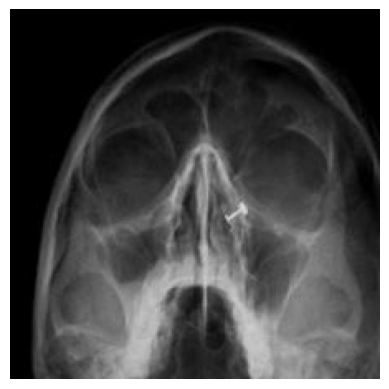

In [9]:

image = Image.open(image_path).convert("RGB")

# Show the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

### Predict the maxillary area  


0: 640x640 2 rights, 53.0ms
Speed: 4.0ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


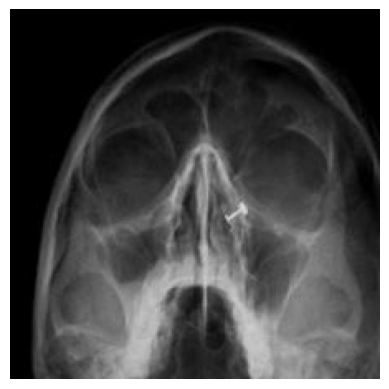

In [16]:
yolo_model = YOLO(model_path)
img = cv2.imread(image_path)


# if you want all classes
yolo_classes = list(yolo_model.names.values())
classes_ids = [yolo_classes.index(clas) for clas in yolo_classes]
 
conf = 0.5

# results = model.predict(img)
yolo_results = yolo_model.predict(img, conf=conf)

colors = [random.choices(range(256), k=3) for _ in classes_ids]

plt.imshow(img)
plt.axis('off')
plt.show()

### Save

In [ ]:
# reset the image
img = cv2.imread(image_path)

for result in yolo_results:
    for mask, box in zip(result.masks.xy, result.boxes):
        points = np.int32([mask])
        # cv2.polylines(img, points, True, (255, 0, 0), 1)
        color_number = classes_ids.index(int(box.cls[0]))
        cv2.fillPoly(img, points, colors[color_number])

  
# Convert BGR to RGB for displaying correctly in matplotlib 
plt.imshow(img)
plt.axis('off')
plt.show()

output_file = "./output/output.jpg"
cv2.imwrite(output_file, img)
print(f"Image saved as {output_file}")

### Save Result With Labels (From the docs)

boxes:  ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1., 1.])
conf: tensor([0.8501, 0.8079])
data: tensor([[ 40.1046, 108.0865, 108.4371, 197.4097,   0.8501,   1.0000],
        [130.5201, 116.4996, 189.9526, 211.8733,   0.8079,   1.0000]])
id: None
is_track: False
orig_shape: (224, 224)
shape: torch.Size([2, 6])
xywh: tensor([[ 74.2708, 152.7481,  68.3325,  89.3231],
        [160.2363, 164.1864,  59.4325,  95.3737]])
xywhn: tensor([[0.3316, 0.6819, 0.3051, 0.3988],
        [0.7153, 0.7330, 0.2653, 0.4258]])
xyxy: tensor([[ 40.1046, 108.0865, 108.4371, 197.4097],
        [130.5201, 116.4996, 189.9526, 211.8733]])
xyxyn: tensor([[0.1790, 0.4825, 0.4841, 0.8813],
        [0.5827, 0.5201, 0.8480, 0.9459]])
masks:  None
keypoints:  None
probs:  None
obb:  None


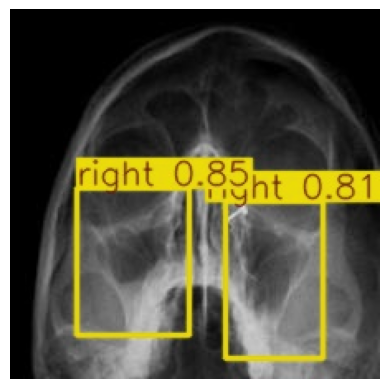

In [17]:
# reset the image
img = cv2.imread(image_path)
 

# Process results list
for result in yolo_results:
   boxes = result.boxes  # Boxes object for bounding box outputs
   masks = result.masks  # Masks object for segmentation masks outputs
   keypoints = result.keypoints  # Keypoints object for pose outputs
   probs = result.probs  # Probs object for classification outputs
   obb = result.obb  # Oriented boxes object for OBB outputs
   # result.show()  # display to screen
   
   result.save(filename="output/result.jpg")  # save to disk
   
   print("boxes: ", boxes)  
   print("masks: ", masks)  
   print("keypoints: ", keypoints)  
   print("probs: ", probs)  
   print("obb: ", obb)  
   

# Convert BGR to RGB for displaying correctly in matplotlib 
result_img = cv2.imread("output/result.jpg")
plt.imshow(result_img)
plt.axis('off')
plt.show()
    

### Save Mask

In [ ]:
import os

# reset the image
img = cv2.imread(image_path)

# Ensure the output directory exists
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)

H, W, _ = img.shape

# Create a blank mask initialized with zeros
combined_mask = np.zeros((H, W), dtype='uint8')

# Combine all detected masks
for result in yolo_results:
    for mask in result.masks.data:
        # Convert mask to numpy array and scale to 255
        mask = (mask.numpy() * 255).astype('uint8')

        # Resize mask to match original image dimensions
        resized_mask = cv2.resize(mask, (W, H))

        # Combine with the existing mask
        combined_mask = cv2.bitwise_or(combined_mask, resized_mask)

# Save the combined mask to a single file
mask_filename = os.path.join(output_dir, 'combined_mask.png')
cv2.imwrite(mask_filename, combined_mask)
print(f"Saved combined mask to {mask_filename}")


# Convert BGR to RGB for displaying correctly in matplotlib 
img = cv2.imread(mask_filename)
plt.imshow(img)
plt.axis('off')
plt.show()
 

In [ ]:
 
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load InceptionV3 model
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation="softmax")(x)  # 3 classes: mild, moderate, severe
severity_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
severity_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


# Function to dynamically crop maxillary regions and classify
def detect_and_classify(yolo_results):
    # Predict with YOLO 

    # Iterate through results (one image in this case)
    for result in yolo_results:
        # Get bounding boxes for the maxillary sinus
        boxes = result.boxes.xyxy  # (x_min, y_min, x_max, y_max)
        original_image = result.orig_img  # Original image in numpy format
        
        for box in boxes:
            # Extract bounding box coordinates
            x_min, y_min, x_max, y_max = map(int, box)

            # Crop the region
            cropped_region = original_image[y_min:y_max, x_min:x_max]

            # Resize to fit InceptionV3 input size
            resized_region = cv2.resize(cropped_region, (224, 224))

            # Normalize the pixel values
            resized_region = resized_region / 255.0

            # Expand dimensions to create a batch of size 1
            input_data = np.expand_dims(resized_region, axis=0)

            # Classify the cropped region with InceptionV3
            predictions = severity_model.predict(input_data)
            class_label = np.argmax(predictions, axis=1)  # Get the class label
            confidence = predictions[0][class_label[0]]

            print(f"Predicted Class: {class_label[0]}, Confidence: {confidence:.2f}")


# Example: Detect and classify an image
detect_and_classify(yolo_results)


c:\Python310\lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


1/1 [==============================] - 1s 1s/step
Predicted Class: 0, Confidence: 0.44
1/1 [==============================] - 0s 55ms/step
Predicted Class: 0, Confidence: 0.65
